In [1]:
import pandas as pd
dataset = pd.read_csv('spam.csv', encoding='latin-1')
print(dataset.head())
print(dataset.info())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
m

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

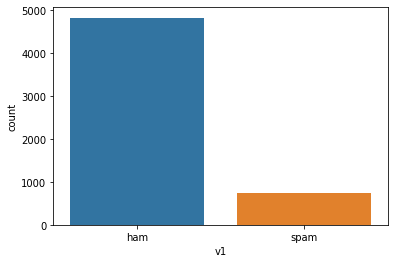

In [3]:
sns.countplot(data=dataset, x=dataset['v1'])

In [4]:
text = dataset.loc[:, 'v2']
classification = dataset.loc[:, 'v1']
print(text)
print(classification)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object
0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object


In [5]:
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
x_train, x_test, y_train, y_test = train_test_split(text, classification, test_size=0.2, random_state=42)

In [7]:
text_length = []
for i in x_train :
  text_length.append(len(word_tokenize(i)))

In [8]:
print(max(text_length))

220


In [9]:
from keras.preprocessing.text import Tokenizer

In [10]:
max_sequence_length = 38

tok = Tokenizer()
tok.fit_on_texts(x_train.values)

In [11]:
vocab_length = len(tok.word_index)

In [12]:
vocab_length = len(tok.word_index)

In [13]:
x_train_sequences = tok.texts_to_sequences(x_train.values)
x_test_sequences = tok.texts_to_sequences(x_test.values)

In [14]:
from tensorflow.keras.utils import pad_sequences

In [15]:
x_train = pad_sequences(x_train_sequences, maxlen=max_sequence_length)
x_test = pad_sequences(x_test_sequences, maxlen=max_sequence_length)

In [16]:
x_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   38,   30,    8,
           5,  273, 1989,   81,  116,   26,   11, 1656,  322,   10,   53,
          18,  299,   30,  349, 1990],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  799,   15, 2555, 1442, 1127,  192, 2556,
         171,   12,   98, 1991,   44,  195, 1657, 2557, 1992, 2558,   21,
           9,    4,  203, 1025,  225]], dtype=int32)

In [17]:
y_train.values

array(['ham', 'spam', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
print(y_train)

[0 1 0 ... 0 0 0]


In [20]:
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop

In [21]:
def create_model(vocab_len, max_seq_len):
    inputs = Input(name='inputs', shape=[max_seq_len])   #None, 150
    layer = Embedding(vocab_length + 1, 50, input_length=max_seq_len)(inputs) #None, 150, 50
    layer = LSTM(64)(layer)  #None, 64
    layer = Dense(256,name='FC1')(layer) #None, 256
    layer = Activation('relu')(layer) #None, 256
    layer = Dropout(0.5)(layer) #None, 256
    layer = Dense(1,name='out_layer')(layer) #None, 1
    layer = Activation('sigmoid')(layer) #None, 1
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['acc'])
    return model

model = create_model(vocab_length, max_sequence_length)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 38)]              0         
                                                                 
 embedding (Embedding)       (None, 38, 50)            397750    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [23]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
28/28 [==============================] - 6s 94ms/step - loss: 0.3199 - acc: 0.8746 - val_loss: 0.1659 - val_acc: 0.9462
Epoch 2/20
28/28 [==============================] - 2s 71ms/step - loss: 0.0999 - acc: 0.9778 - val_loss: 0.0555 - val_acc: 0.9821
Epoch 3/20
28/28 [==============================] - 2s 71ms/step - loss: 0.0367 - acc: 0.9916 - val_loss: 0.0388 - val_acc: 0.9854
Epoch 4/20
28/28 [==============================] - 2s 71ms/step - loss: 0.0180 - acc: 0.9952 - val_loss: 0.0450 - val_acc: 0.9854
Epoch 5/20
28/28 [==============================] - 2s 70ms/step - loss: 0.0096 - acc: 0.9975 - val_loss: 0.0410 - val_acc: 0.9854
Epoch 6/20
28/28 [==============================] - 2s 69ms/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0569 - val_acc: 0.9877
Epoch 7/20
28/28 [==============================] - 2s 72ms/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.0739 - val_acc: 0.9854
Epoch 8/20
28/28 [==============================] - 2s 70ms/step - loss: 7.7716e-04

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


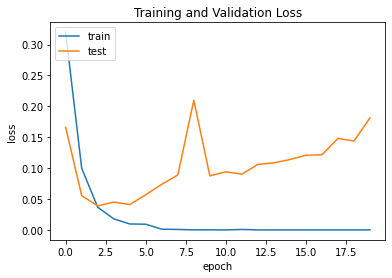

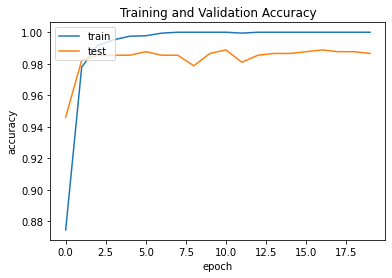

In [24]:
history_dict = history.history

# list all data in history
print(history_dict.keys())

# summarize history for loss
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_dict['acc'])
plt.plot(history_dict['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model.save('/content/drive/MyDrive/spam.h5')

In [26]:
loaded_model = load_model('/content/drive/MyDrive/spam.h5')
test_loss, test_acc = accr = loaded_model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_acc))

35/35 [==============================] - 1s 11ms/step - loss: 0.2557 - acc: 0.9830
Test set
  Loss: 0.256
  Accuracy: 0.983


In [27]:
import numpy as np

In [28]:
y_pred_prob = loaded_model.predict(x_test)

print(np.round(y_pred_prob, 3))
y_pred = y_pred_prob > 0.5
y_pred

35/35 [==============================] - 1s 8ms/step
[[0.   ]
 [0.   ]
 [0.995]
 ...
 [0.   ]
 [0.   ]
 [1.   ]]


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [29]:
for i in range(5):
    print('%s => %d (expected %d)' % (x_test[i].tolist(), y_pred[i], y_test[i]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1366, 1578, 1432, 19, 7893, 19, 19, 38, 118, 1650, 19, 738, 4, 449, 3023, 35, 1285] => 0 (expected 0)
[1, 188, 11, 6440, 2, 7, 1, 135, 2, 28, 12, 4, 290, 7931, 1, 104, 33, 3, 22, 647, 15, 28, 4, 3607, 18, 374, 191, 224, 2137, 107, 433, 9, 74, 10, 5, 1097, 1806, 1171] => 0 (expected 0)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 54, 258, 144, 3, 54, 21, 3428, 3, 16, 2, 173, 53, 144, 761, 264, 7182, 208] => 1 (expected 1)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 33, 3, 1528, 13, 263, 53, 79, 228, 79, 3, 31, 7, 838, 69, 10, 8, 5, 168, 2, 205, 10, 54, 3, 499, 14, 8, 46] => 0 (expected 0)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 715, 29, 357, 532, 622, 15, 1107, 528, 706, 49, 435, 19, 98, 563, 496, 292, 71, 521, 2, 906, 1546, 138, 1200, 2216] => 1 (expected 1)


In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

